# Опечатки: что с ними делать

### Основные типы опечаток

* замена буквы в слове на соседнюю по клавиатуре или случайную — «**gолоко**» вместо «**молоко**»;
* добавление лишней буквы — «**молокео**»;
* случайное удаление буквы — «**молоо**»;
* перестановка двух соседних букв слова местами — «**млооко**»;
* дублирование буквы в слове — «**ммолоко**»;
* отсутствие необходимого пробела — «**пастеризованноемолоко**»;
* двойной пробел — «**пастеризованное  молоко**»;
* орфографические ошибки: «**а**» вместо «**о**», «**и**» вместо «**е**» и т. д.;
* неверная раскладка — «**vjkjrj**» вместо «**молоко**»

В целом исправление опечаток делится на 
+ **контекстно-независимое**   
VS
+ **контекстно-зависимое** (*то есть где учитывается контекст*)

В первом случае ошибки исправляются для каждого слова по отдельности, во втором учитывается контекст (например, для фразы «она пошле домой» в контекстно-независимом случае исправление происходит для каждого слова в отдельности, где мы можем получить «она пошел домой», а во втором случае правильное исправление выдаст «она пошла домой»).

> Пользователи совершают опечатки приблизительно в 10-15% случаях. При этом 83,6% запросов имеют одну ошибку, 11,7% – две, 4,8% – более трёх. Контекст важен в 26% случаев.  
Эта статистика была составлена на основе случайной выборки из дневного лога Яндекса в далеком 2013 году на основе 10000 запросов. В открытом доступе есть гораздо более ранняя презентация от Яндекса за 2008 год, где показано похожее распределение статистики. Отсюда можно сделать вывод, что распределение разновидностей ошибок для поисковых запросов, в среднем, с течением времени не изменяется.

Если у нас ограниченный набор слов, можно использовать словарь опечаток с правильными словами, но это слишком сложно и нужна большая подготовка:
1. лемматизировать все слова, например, из набора текстов
2. сгенерировать ВСЕ варианты опечаток и соотнести их в словаре с правильным словом
3. при добавлении новых слов, обязательно добавлять их в словарь

В общем случае для исправления ошибок существует две модели: модель ошибок и языковая модель. Для контекстно-независимого исправления используется только модель ошибок, для зависимого — обе модели.

### Расстояние Левенштейна

**Расстояние Левенштейна** — метрика cходства между двумя строковыми последовательностями. Чем больше расстояние, тем более различны строки. Для двух одинаковых последовательностей расстояние равно нулю. По сути, это минимальное число односимвольных преобразований (удаления, вставки или замены), необходимых, чтобы превратить одну последовательность в другую.

|  | К | О | Т | И | К | |  
|----------|----------|----------|----------|----------|----------|----------|
| С | К | О | Т | И | Н | А |

#### Какое расстояние?

In [ ]:
def levenstein(str_1, str_2):
    n, m = len(str_1), len(str_2)
    if n > m:
        str_1, str_2 = str_2, str_1
        n, m = m, n

    current_row = range(n + 1)
    for i in range(1, m + 1):
        previous_row, current_row = current_row, [i] + [0] * n
        for j in range(1, n + 1):
            add, delete, change = previous_row[j] + 1, current_row[j - 1] + 1, previous_row[j - 1]
            if str_1[j - 1] != str_2[i - 1]:
                change += 1
            current_row[j] = min(add, delete, change)

    return current_row[n]

Можно оставлять стоимость каждой операции (замена, удаление, вставка) как единицу, можно делать для них разные веса.

#### Какая сложность алгоритма?

Можно не изобретать велосипед, и взять готовую реализацию:
1. есть [библиотека на Python](https://pypi.org/project/python-Levenshtein/) (изначально написана на C)
2. есть [метод в NLTK](https://www.nltk.org/_modules/nltk/metrics/distance.html)

### Расстояние Левенштейна-Дамерау

То же, но с учётом операции перестановки (транспозиции) символов.

In [ ]:
def damerau_levenshtein_distance(s1, s2):
    d = {}
    lenstr1 = len(s1)
    lenstr2 = len(s2)
    for i in range(-1,lenstr1+1):
        d[(i,-1)] = i+1
    for j in range(-1,lenstr2+1):
        d[(-1,j)] = j+1
 
    for i in range(lenstr1):
        for j in range(lenstr2):
            if s1[i] == s2[j]:
                cost = 0
            else:
                cost = 1
            d[(i,j)] = min(
                           d[(i-1,j)] + 1, # deletion
                           d[(i,j-1)] + 1, # insertion
                           d[(i-1,j-1)] + cost, # substitution
                          )
            if i and j and s1[i] == s2[j-1] and s1[i-1] == s2[j]:
                d[(i,j)] = min(d[(i,j)], d[i-2,j-2] + 1) # transposition
 
    return d[lenstr1-1,lenstr2-1]

При этом! Алгоритм круто работает, НЕ используя статистику по самым частотным опечаткам! Одновременно с этим модель Бриля-Мура, работающая на вероятностях перехода строки в строку, работает хуже, опираясь при этом на статистику.

### Алгоритм Питера Норвига

Питер Норвиг описал простой вариант спеллчекера. Для каждого слова генерируются все возможные варианты изменений (удаления + вставки + замены + перестановки), рекурсивно с глубиной <= 2. Получившиеся слова проверяются на наличие в словаре (хеш-таблица), среди множества подошедших вариантов выбирается тот, который встречается чаще всего. 
Основные недостатки данного спеллчекер:  
+ долго работает (особенно на длинных словах),
+ не учитывается контекст

Для начала собираем в словарь частотный словарь слов, а также добавляем функцию, считающую вероятность слов.

In [ ]:
import re
from collections import Counter

def words(text): 
    return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('big.txt').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

Далее
+ функции, генерирующие все возможные вариации слова
+ функция, возвращаюся пересечение множества полученных вариаций и исходного списка слов

|тип операции|||||||
|--|--|--|--|--|--|--|
|пары:	|Ø+wird	|w+ird|	wi+rd	|wir+d	|wird+Ø	|*Notes: (a, b) пара*|
|удаления:	|Ø+ird	|w+rd|	wi+d	|wir+Ø|		|*Удаление первой буквы в b*|
|перемена мест:	|Ø+iwrd	|w+rid	|wi+dr		|||	*Перемена мест двух первых букв b*|
|замена:	|Ø+?ird	|w+?rd	|wi+?d|	wir+?	||	*замена буквы в начале b*|
|вставка:	|Ø+?+wird|	w+?+ird|	wi+?+rd	|wir+?+d	|wird+?+Ø	|*Вставка буквы между a и b*|


In [ ]:
def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

Наконец добавляем функции для генерации всех кандидатов, попадающих в пересечение с исходным списком слов, и для возвращения наиболее вероятного слова.

In [ ]:
def candidates(word): 
    "Generate possible spelling corrections for word."
    # предрассчитать edit_distance==0, затем 1, затем 2; в противном случае оставить слово "как есть".
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

### SymSpell

Один из вариантов ускорения производительности — алгоритм SymSpell, который, по заверению авторов, работает в миллион раз быстрее. SymSpell работает по следующему принципу: для каждого слова из словаря в отдельный индекс добавляются удаления, а точнее — все слова, получившиеся из исходного путём удаления одной или нескольких букв (обычно 1 и 2), со ссылкой на оригинальное слово. В момент поиска кандидатов для слова делаются аналогичные удаления и проверяется их наличие в индексе. Такой алгоритм корректно обрабатывает все случаи ошибок — замены букв, перестановки, добавления и удаления.  

Для примера рассмотрим замену (в примере будем учитывать только расстояние 1). Пусть в оригинальном словаре содержится слово "**тест**". А мы набрали слово “**темт**”. В индексе будут находится все удаления слова “**тест**”, а именно: **ест, тст, тет, тес**. Для слова “**темт**” удаления будут: **емт, тмт, тет, емт**. Удаление “**тет**” содержится в индексе, значит слову с опечаткой “**темт**” соответствует слово “**тест**”.

### Как оценить качество работы спеллчекеров?

Основные метрики — **точность (precision)** и **полнота (recall)**.  

Вообще полнота и точность из машинного обучения. Попробуем разобраться на самом простом примере.  
Пусть у нас есть Вася, который сторожит овец, и волк, который нападает на овец ночью. Вася любит пугать жителей ночью и будит всех со словами: “Волк!”. Но также бывает, что волк на самом деле приходит ночью. Так вот, когда Вася кричит и волк на самом деле появился, то это True Positive (TP). Когда Вася кричит и волка нет, то это False Positive (FP). Когда Вася не кричит и волк пришёл, то это False Negative (FN). А когда Вася не кричит и волк не пришел, то это True Negative (TN).

Другими словами, Positive и Negative - это предсказания нашей модели (изображена ли на этой картинке кошка), а True и False- это оценка того, правильно ли определила модель наш класс (действительно ли на этой картинке кошка). Крик Васи — предсказание модели. Пришёл Волк — то, что на самом деле произошло, и относительно чего дается оценка (True или False) крику нашего Васи.

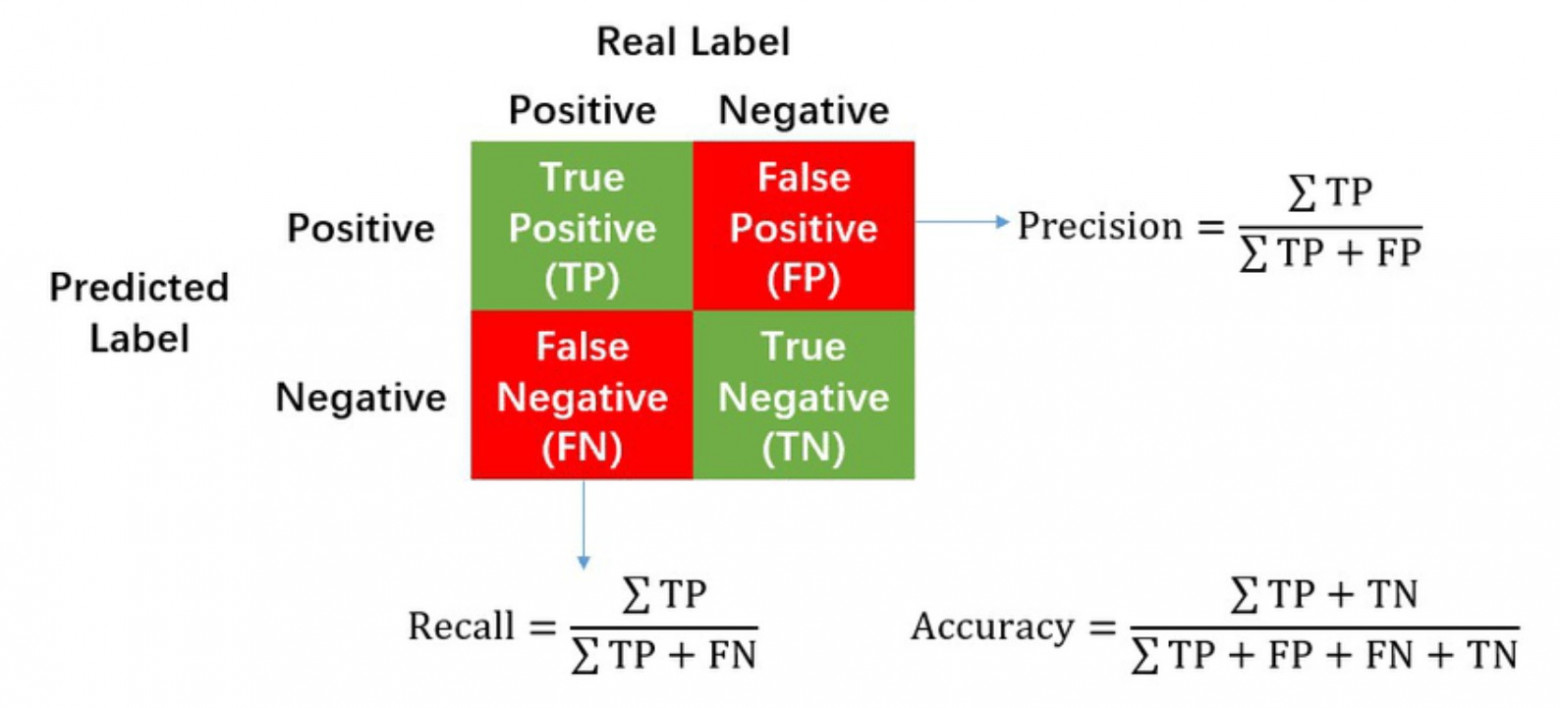

#### Что в спелл-чекере?

**Полнота (recall)** рассчитывается следующим образом: список из правильных слов подается автокорректору (total_list_true), и, количество слов, которое автокорректор считает правильными (spellchecker_true), разделенное на общее количество правильных слов (total_list_true), будет считаться полнотой.

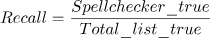

Для определения **точности (precision)** на вход автокорректора подается список из неправильных слов (total_list_false), и, количество слов, которое автокорректор считает неправильным (spell_checker_false), разделенное на общее количество неправильных слов (total_list_false), определяют как точность.

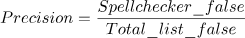

Фактически суть данной проверки сводится к тому, что проверяется вхождение слова в обучающий словарь. 

Возможно более наглядной метрикой может быть **правильность (correctness)**. Автокорректор для каждого слова из тестового множества неправильных слов формирует список кандидатов-замен, на которые можно исправить это неправильное слово (следует иметь в виду, что здесь могут оказаться слова, которые не содержатся в обучающем словаре). Допустим, размер такого списка кандидатов-замен равен 5. Исходя из того, что размер списка равен 5, будет сформировано 6 групп, в одну из которых мы будем помещать наше каждое исходное неправильное слово по следующему принципу: в 1-ую группу — если в списке кандидатов-замен предполагаемое нами правильное слово стоит 1-ым, во 2-ую если стоит 2-ым и т. д., а в последнюю группу — если предполагаемого правильного слова в списке кандидатов-замен не оказалось. Таким образом, чем больше слов попало в 1-ую группу и чем меньше в 6-ую, тем лучше работает автокорректор.

### JamSpell

Быстрый производительный спелл-чекер, использующий обе модели: модель ошибок и языковую. 

Попробуйте скачать готовую обученную модель для [русского](https://github.com/bakwc/JamSpell-models/raw/master/ru.tar.gz) или [английского](https://github.com/bakwc/JamSpell-models/raw/master/en.tar.gz) языка и протестируйте её.  
Пример использования:

In [ ]:
import jamspell

corrector = jamspell.TSpellCorrector()
corrector.LoadLangModel('model_en.bin')

corrector.FixFragment('I am the begt spell cherken!')
# u'I am the best spell checker!'

corrector.GetCandidates(['i', 'am', 'the', 'begt', 'spell', 'cherken'], 3)
# (u'best', u'beat', u'belt', u'bet', u'bent', ... )

corrector.GetCandidates(['i', 'am', 'the', 'begt', 'spell', 'cherken'], 5)
# (u'checker', u'chicken', u'checked', u'wherein', u'coherent', ...)

### Яндекс.Спеллер

Для Яндекс Спеллера есть питоновская библиотека, которая упрощает его использование. У него есть некоторые ограничения (10 к запросов в день), но для небольших проектов этого вполне достаточно.

In [2]:
pip install pyaspeller

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
djoser 2.1.0 requires importlib-metadata<2.0,>=1.0; python_version < "3.8", but you have importlib-metadata 4.13.0 which is incompatible.



   ---------------------------------------- 62.6/62.6 kB 844.1 kB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Uninstalling requests-2.26.0:
      Successfully uninstalled requests-2.26.0


In [3]:
# Так можно исправить предложение целиком
from pyaspeller import YandexSpeller
speller = YandexSpeller()
fixed = speller.spelled('Для Яндекс Спеллера есь питоновская библиатека, которай упрощает его использование. У него есть некоторые ограничения (10 к запросов в день), но для небольших проектов этого вполне достаточно.')
fixed

'Для Яндекс Спеллера есть питоновская библиотека, которая упрощает его использование. У него есть некоторые ограничения (10 к запросов в день), но для небольших проектов этого вполне достаточно.'

In [4]:
# А так проверить и исправить отдельное слово
from pyaspeller import Word
check = Word('приджлажение')
print(check.text, check.correct, check.spellsafe, check.variants)

c:\Users\aomak\AppData\Local\Programs\Python\Python37\lib\site-packages\pyaspeller\word.py:17: UserWarning: Class Word is deprecated. Use YandexSpeller().spelled(text) instead
  warnings.warn("Class Word is deprecated. Use YandexSpeller().spelled(text) instead")


приджлажение False предложение ['предложение', 'придлажение', 'приджложение']
